<a href="https://colab.research.google.com/github/AnilKumar-06/Movie-Recommandation/blob/main/NetflixRecommandationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
from google.colab import drive
drive.mount('/content/drive/') 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **Problem Description**

Netflix is all about connecting people to the movie they love. To help cutomes find those movies, they devloped world-class recommandation system **CinematchSM**. Its job is to predict whether someone will enjoy a movie based on how much they liked or disliked other movies. Netflix use those predictions to make personal movie recommandations based on each customer's unique tastes. And while **Cinematch** is doing pretty well, it can always be made better.


Now there are a lot of interesting alternative approaches to how Cinematch works that netflix have not tried.Some are descibed in the literature, some are not. we are curious whether any of these can beat Cinematch by making better prediction. Because, if there are much better approachm it could make a big diffrence to our customers and our business 

Credits: https://www.netflixprize.com/rules.html

# **Problem Statment**

Netflix provided a lot of anonymous rating data, and a prediction accuracy bar that is 10% better than what Cinematch can do on the same training dataset. (Accuracy is a measurement of how closely predicted ratings of movies match subsequent actual ratings.)

In [3]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
#matplotlib.use('nbagg')

import matplotlib.pyplot as plt
#plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

In [4]:

start = datetime.now()
if not os.path.isfile('data.csv'):
  data = open('data.csv', mode='w')
  row = list()
  files = ['/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/combined_data_1.txt']#,'/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/combined_data_2.txt']#, '/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/combined_data_3.txt', '/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/combined_data_4.txt']

  for file in files:
    print('Reading rating from {}...'.format(file))
    with open(file) as f:
      for line in f:
        del row[:] #you don't have to do this
        line = line.strip()
        if line.endswith(':'):
          #all below are rating for this movie, until another
          movie_id = line.replace(':', '')
        else:
          row = [x for x in line.split(',')]
          row.insert(0, movie_id)
          data.write(','.join(row))
          data.write('\n')

    print('Done.\n')
  data.close()
  print('Time taken :',datetime.now() - start)

Reading rating from /content/drive/MyDrive/ML_Projects/NetflixRecoomandation/combined_data_1.txt...
Done.

Time taken : 0:00:40.716407


In [5]:
print("Creating the dataframe from data.csv file...")
df = pd.read_csv('data.csv', sep=',',names = ['movie', 'user', 'rating', 'date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

#arranging the rating according to time
print('Sorting the datetime by date...')
df.sort_values(by='date', inplace=True)
print('Done..')

Creating the dataframe from data.csv file...
Done.

Sorting the datetime by date...
Done..


In [6]:
df.head()

,movie,user,rating,date
9056171,1798,510180,5,1999-11-11
14892677,2866,510180,3,1999-11-11
19585852,3730,510180,4,1999-11-11
20393918,3870,510180,2,1999-11-11
6901473,1367,510180,5,1999-11-11


In [7]:
df.describe()['rating']

count    2.405376e+07
mean     3.599634e+00
std      1.086118e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [8]:
# Just to make sure that all NAN containing rows are deleted..

print("Number of Nan values in our dataframe : ", sum(df.isnull().any()))

Number of Nan values in our dataframe :  0


Removing Duplicates

In [9]:
dup_bool = df.duplicated(['movie', 'user', 'rating'])
dups = sum(dup_bool) #by considering all columns..(including timestamp)
print("There are {} duplicate rating entries in the data...".format(dups))

There are 0 duplicate rating entries in the data...


Basic Statistics(# of Rating, # of Users, # of Movies)

In [10]:
print("Total Data")
print("-"*70)
print("\nTotal no. of rating : ",df.shape[0])
print("Total No. of Users : ", len(np.unique(df.user)))
print("Total No. of Movies : ", len(np.unique(df.movie)))

Total Data
----------------------------------------------------------------------

Total no. of rating :  24053764
Total No. of Users :  470758
Total No. of Movies :  4499


Spliting data into Train and Test

In [11]:
if not os.path.isfile('train.csv'):
  #create the dataframe and store it in the disk for offline purpose...
  df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
  #creating the dataframe and store it in the disk for offline purpose...
  df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index = False)

train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")

Basic statistic in Train data (# of Ratings # of Users and # of Movies)

In [12]:
# movies = train_df.movie.value_counts()
# users = train_df.user.value_counts()
print("Training data")
print("-"*70)
print("\nTotal no of ratings : ",test_df.shape[0])
print("Total no of Users : ", len(np.unique(test_df.user)))
print("Total no. of movies : ", len(np.unique(test_df.movie)))

Training data
----------------------------------------------------------------------

Total no of ratings :  4810753
Total no of Users :  302727
Total no. of movies :  4497


EDA On Train data

In [13]:
def human(num, units = "M"):
  units = units.lower()
  num = float(num)
  if units == 'k':
    return str(num/10**3) + 'K'
  elif units == 'M':
    return str(num/10**6) + 'M'
  elif units == 'b':
    return str(num/10**9) + 'B'


Distribution of ratings

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


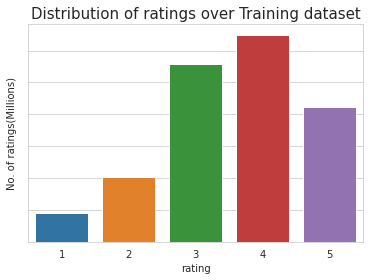

In [14]:
fig, ax = plt.subplots()
plt.title("Distribution of ratings over Training dataset", fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel("No. of ratings(Millions)")
plt.show()

In [15]:
# It is used to skip the warnings 'SettingWithCopyWarning'...
pd.options.mode.chained_assignment = None        #default = 'warn'
train_df['day_of_week'] = train_df.date.dt.day_name()
#df['day_of_week'] = df['mydate'].dt.day_name() 
train_df.head(20)



,movie,user,rating,date,day_of_week
0,1798,510180,5,1999-11-11,Thursday
1,2866,510180,3,1999-11-11,Thursday
2,3730,510180,4,1999-11-11,Thursday
3,3870,510180,2,1999-11-11,Thursday
4,1367,510180,5,1999-11-11,Thursday
5,2948,510180,3,1999-12-06,Monday
6,3421,510180,3,1999-12-06,Monday
7,2478,510180,3,1999-12-06,Monday
8,1615,122223,3,1999-12-08,Wednesday
9,2780,122223,3,1999-12-08,Wednesday


In [16]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count()
no_of_rated_movies_per_user.head()

user
6     105
7     190
10     38
25      2
33      8
Name: rating, dtype: int64

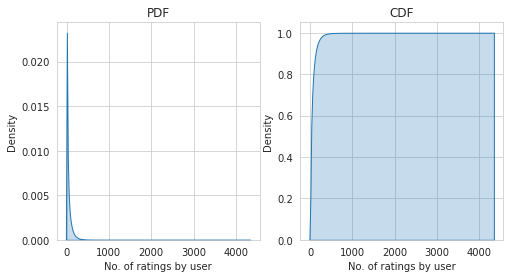

In [17]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel("No. of ratings by user")
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True, ax=ax2)
plt.xlabel("No. of ratings by user")
plt.title('CDF')
plt.show()

In [18]:
no_of_rated_movies_per_user.describe()

count    389223.000000
mean         49.439553
std          71.463434
min           1.000000
25%           8.000000
50%          23.000000
75%          62.000000
max        4326.000000
Name: rating, dtype: float64

In [19]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0, 1.01, 0.01))

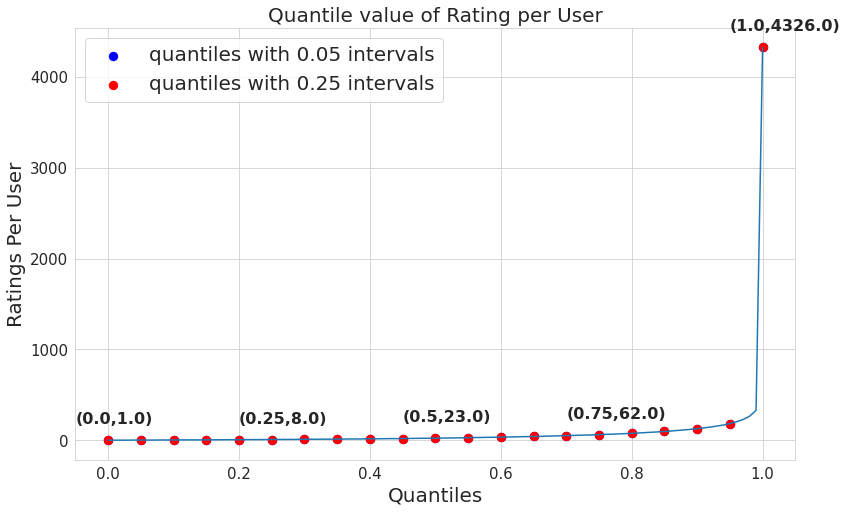

In [20]:
fig = plt.figure(figsize = (10, 6))
axes = fig.add_axes([0.1, 0.1, 1, 1])
axes.set_title("Quantile value of Rating per User", fontsize = 20)
axes.set_xlabel("Quantiles", fontsize = 20)
axes.set_ylabel("Ratings Per User", fontsize = 20)
axes.plot(quantiles)

plt.scatter(x = quantiles.index[::5], y=quantiles.values[::5], c='blue', s=70, label="quantiles with 0.05 intervals")

plt.scatter(x = quantiles.index[::5], y=quantiles.values[::5], c="red", s=70, label = "quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize = 20)

for x, y in zip(quantiles.index[::25], quantiles.values[::25]):plt.annotate(s='({},{})'.format(x,y), xy = (x,y),fontweight
                                                                            ='bold', fontsize = 16, xytext=(x-0.05, y+180))

axes.tick_params(labelsize = 15)

In [21]:
quantiles[::5]

0.00       1.0
0.05       2.0
0.10       3.0
0.15       5.0
0.20       6.0
0.25       8.0
0.30      10.0
0.35      13.0
0.40      16.0
0.45      19.0
0.50      23.0
0.55      28.0
0.60      35.0
0.65      42.0
0.70      51.0
0.75      62.0
0.80      77.0
0.85      97.0
0.90     128.0
0.95     184.0
1.00    4326.0
Name: rating, dtype: float64

In [22]:
print("Total number of ratings below 75th percentile = "+str(sum(no_of_rated_movies_per_user.values<=133)))
print("Total number of ratings above 75th percentile = "+str(sum(no_of_rated_movies_per_user.values>133)))

Total number of ratings below 75th percentile = 353210
Total number of ratings above 75th percentile = 36013


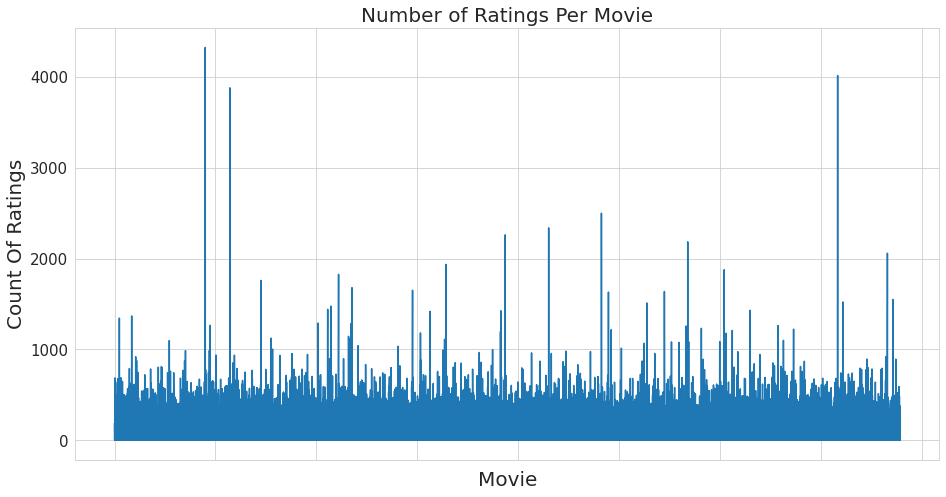

In [23]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize=20)
plt.ylabel("Count Of Ratings", fontsize=20)
plt.plot(no_of_rated_movies_per_user.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

**It is skewed nicely**

It clearly shows that there are some movies which are very popular and were rated by 90% users as comapared to other movies

Number of ratings on each day of the week

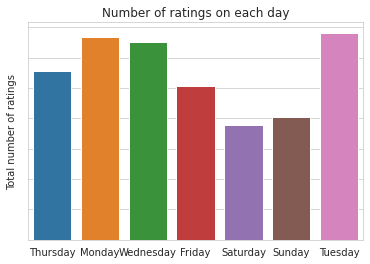

In [24]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data = train_df, ax = ax)
plt.title("Number of ratings on each day")
plt.ylabel('Total number of ratings')
plt.xlabel("")
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

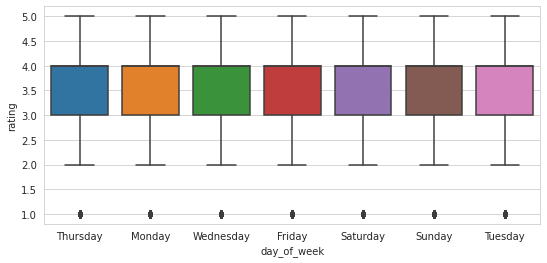

0:00:09.829558


In [25]:
start = datetime.now()
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='rating', x='day_of_week', data=train_df)
plt.show()
print(datetime.now()-start)

In [26]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
print('Average Ratings')
print("_"*30)
print(avg_week_df)
print("\n")

Average Ratings
______________________________
day_of_week
Friday       3.576426
Monday       3.573257
Saturday     3.585673
Sunday       3.588731
Thursday     3.577798
Tuesday      3.570347
Wednesday    3.578739
Name: rating, dtype: float64




Creating sparse matrix from data frame

In [27]:
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
  print("It is present in your pwd, getting it from disk......")
  #just get it from the disk instead of computing it
  train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
  print("Done...")

else:
  print("We are creating sparse matrix from the dataframe.....")
  #create sparse matrix and store it after usages.
  #It should be in such a way that, Matrix[row, col] = data
  train_sparse_matrix = sparse.csr_matrix((train_df.rating.values,(train_df.user.values, train_df.movie.values)),)
  print("Done. It\'s shape is : (user, movie", train_sparse_matrix.shape)
  print("Saving it into disk for further usages...")
  sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
  print("Done.....\n")
  print(datetime.now()-start)

We are creating sparse matrix from the dataframe.....
Done. It's shape is : (user, movie (2649430, 4500)
Saving it into disk for further usages...
Done.....

0:00:14.580908


The sparsity of train sparse matrix

In [28]:
us, mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()
print("Sparsity of train matrix : {} % ".format((1-elem/(us*mv))*100))

Sparsity of train matrix : 99.83859831485766 % 


Creating sparse matrix from test data frame

In [29]:
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
  print("It is present in your pwd, getting it from disk....")
  #just get it from the disk instead of computing it.
  test_sparse_matrix = sparse.load_npz("test_sparse_matrix.npz")
  print("Done....")
else:
  print("We are creating sparse matrix from the dataframe....")
  #create sparse_matrix and store it for after usages
  #It should be in such a way that, matrix[row, col] = data
  test_sparse_matrix = sparse.csr_matrix((test_df.rating.values,(test_df.user.values, test_df.movie.values)),)
  print("Done. It\'s shape is : (user, movie):", test_sparse_matrix.shape)
  print("Saving it into disk for further usages....")
  #save it into disk
  sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
  print('Done...\n')
print(datetime.now()-start)

We are creating sparse matrix from the dataframe....
Done. It's shape is : (user, movie): (2649430, 4500)
Saving it into disk for further usages....
Done...

0:00:04.135855


The sparsity of test data matrix

In [30]:
us, mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()
print("sparsity of Test matrix : {} % ".format((1-elem/(us*mv))*100))

sparsity of Test matrix : 99.95964957661752 % 


Finding Global Average of all movies ratings, Averages rating per user, and average rating per movie

In [31]:
#get the averages in dictionary(key:user_id/movie_id, value:avg rating)
def get_average_rating(sparse_matrix, of_users):
  #average rating of user/axes
  ax = 1 if of_users else 0 #1-user axes, 0-Movie axes
  #".AI" is for converting column_matrix to 1-D numpy array
  sum_of_ratings = sparse_matrix.sum(axis=ax).A1
  #Boolean matrix of ratings(whether a user rated movie or not)
  is_rated = sparse_matrix != 0
  #no. of ratings that each user or movie
  no_of_ratings = is_rated.sum(axis=ax).A1
  #max_user and max_movie ids in sparse matrix
  u, m = sparse_matrix.shape
  #create a dictionary of users and their averages ratings..
  averages_ratings = { i :sum_of_ratings[i]/no_of_ratings[i] for i in range(u if of_users else m) if no_of_ratings[i] != 0}
  #return that dictionary of average rating
  return averages_ratings


Finding global average of all movie ratings

In [32]:
train_averages = dict()
#get the global avetrage of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.577584765710522}

Finding average rating per users

In [33]:
train_averages['user'] = get_average_rating(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 : ',train_averages['user'][10])



Average rating of user 10 :  3.263157894736842


Finding average rating per movie

In [34]:
train_averages['movie'] = get_average_rating(train_sparse_matrix, of_users=False)
print('\nAverages rating of movie 15 :',train_averages['movie'][15])


Averages rating of movie 15 : 3.312741312741313


PDF's & CDF's of Avg ratings of users and movies(In Train data)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

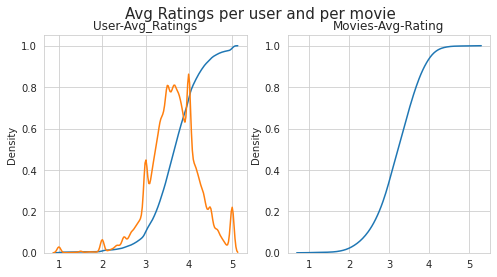

0:00:07.428120


In [35]:
start = datetime.now()
#draw pdfs for averages rating per user and average
fig,(ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle("Avg Ratings per user and per movie",fontsize=15)
ax1.set_title('User-Avg_Ratings')
#get the list average user ratings from the averages dictionary..
user_averages = [rat for rat in train_averages['user'].values()]
sns.distplot(user_averages, ax=ax1, hist=False,kde_kws=dict(cumulative=True),label='Cdf')
sns.distplot(user_averages, ax=ax1,hist=False,label='pdf')

ax2.set_title('Movies-Avg-Rating')
#get the list of movie_average_ratings from the dictionary..
movie_averages = [rat for rat in train_averages['movie'].values()]
sns.distplot(movie_averages, ax=ax2, hist=False, kde_kws=dict(cumulative=True),label='pdf')
plt.show()
print(datetime.now()-start)

Cold start Problem with users

In [36]:
total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users-users_train

print('\nTotal number of users : ',total_users)
print('\nNumber of Users in train data : ',users_train)
print("\nNumber of users that did not appear in train data : {}({} %)".format(new_users,np.round((new_users/total_users)*100, 2)))


Total number of users :  470758

Number of Users in train data :  389223

Number of users that did not appear in train data : 81535(17.32 %)


Cold start problem with movies

In [37]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies-movies_train

print('\nTotal number of movies : ',total_movies)
print('\nNumber of User in train data : ',movies_train)
print("\n No of movies that did not appear in train data : {}({} %)".format(new_movies, np.round((new_movies/total_movies)*100,2)))


Total number of movies :  4499

Number of User in train data :  4403

 No of movies that did not appear in train data : 96(2.13 %)


Computing Similarity matrices

**Computing user-user Similarity matrix**

1. Caculating user user Similarity_matrix is not very easy(unless you have huge Computing Power and lots of time) because of number of usersbeing lare


In [38]:
from sklearn.metrics.pairwise import cosine_similarity
def compute_user_similarity(sparse_matrix, compute_for_few=False, top=100, verbose=False,
                            verb_for_n_rows = 20,draw_time_taken = True):
  no_of_users, _ = sparse_matrix.shape
  #get the indices of non zero rows(users) from our sparse matrix
  row_ind, col_ind = sparse_matrix.nonzero()
  row_ind = sorted(set(row_ind))
  time_taken = list() #time taken forn finding similar users for an user...
  # we create row,cols and data list.., which can be used to create sparse matrices
  rows, cols,data = list(), list(), list()
  if verbose: print("Computing top",top,"similarities for each user...")
  start = datetime.now()
  tmp=0
  for row in row_ind[:top] if compute_for_few else row_ind:
    tmp += 1
    prev = datetime.now()

    #get the similarity row for this user with all other users
    sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
    #we will get only the 'top' most similar users and ignore rest of them
    top_sim_ind = sim.argsort()[-top:]
    top_sim_val = sim[top_sim_ind]
    
    #add them to our row, cols and data
    rows.extend([row]*top)
    cols.extend(top_sim_ind)
    data.extend(top_sim_val)
    time_taken.append(datetime.now().timestamp() - prev.timestamp())

    if verbose:
      if tmp%verb_for_n_rows == 0:
        print("computing done for {} users [time elased : {} ]".format(tmp, datetime.now()-start))


    # lets create sparse matrix out of these and return it
  if verbose: print("Creating sparse matrix from the computed similarities")

      #return rows, cols, data

  if draw_time_taken:
    plt.plot(time_taken, label = 'time taken for each user')
    plt.plot(np.cumsum(time_taken), label='Total time')
    plt.legend(loc='best')
    plt.xlabel('User')
    plt.ylabel('Time(seconds)')
    plt.show()
  return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken

Computing top 40 similarities for each user...
computing done for 20 users [time elased : 0:00:14.255533 ]
computing done for 40 users [time elased : 0:00:28.575484 ]
Creating sparse matrix from the computed similarities


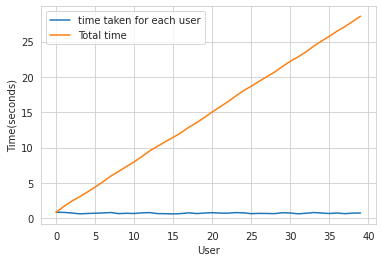

----------------------------------------------------------------------------------------------------
Time taken : 0:00:31.473053


In [39]:
# We are not going to run it on whole data it will gives us memory error or so we will try it on 100
start = datetime.now()
u_u_sim_sparse, _ = compute_user_similarity(train_sparse_matrix, compute_for_few=True, top = 40,verbose=True)
print("-"*100)
print("Time taken :",datetime.now()-start)

Trying with reduced dimensions (Using TruncatedSVD for dimensionality reduction of user vector)
We have 405,041 users in out training set and computing similarities between them..( 17K dimensional vector..) is time consuming..
From above plot, It took roughly 8.88 sec for computing simlilar users for one user
We have 405,041 users with us in training set.
${ 405041 \times 8.88 = 3596764.08  \sec } =  59946.068 \min = 999.101133333 \text{ hours}
= 41.629213889 \text{ days}...$

Even if we run on 4 cores parallelly (a typical system now a days), It will still take almost 10 and 1/2 days.
IDEA: Instead, we will try to reduce the dimentsions using SVD, so that it might speed up the process...



In [40]:
from datetime import datetime
from sklearn.decomposition import TruncatedSVD
start = datetime.now()
#initilize the algorithm with some parameter
#All of them are default except n_component. n_iter is for randomized SVD solver
netflix_svd = TruncatedSVD(n_components=40, algorithm='randomized', random_state=15)
trunc_svd = netflix_svd.fit_transform(train_sparse_matrix)
print(datetime.now()-start)

0:00:56.945843



Here,

$\sum \longleftarrow$ (netflix_svd.singular_values_ )

$\bigvee^T \longleftarrow$ (netflix_svd.components_)

$\bigcup$ is not returned. instead Projection_of_X onto the new vectorspace is returned.

It uses randomized svd internally, which returns All 3 of them saperately. Use that instead.

In [41]:
expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)


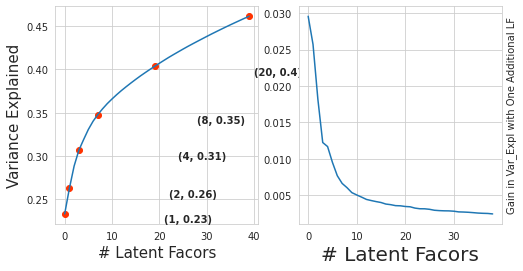

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))

ax1.set_ylabel("Variance Explained", fontsize=15)
ax1.set_xlabel("# Latent Facors", fontsize=15)
ax1.plot(expl_var)
# annote some (latentfactors, expl_var) to make it clear
ind = [1, 2,4,8,20,40]
ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c='#ff3300')
for i in ind:
    ax1.annotate(s ="({}, {})".format(i,  np.round(expl_var[i-1], 2)), xy=(i-1, expl_var[i-1]),
                xytext = ( i+20, expl_var[i-1] - 0.01), fontweight='bold')

change_in_expl_var = [expl_var[i+1] - expl_var[i] for i in range(len(expl_var)-1)]
ax2.plot(change_in_expl_var)



ax2.set_ylabel("Gain in Var_Expl with One Additional LF", fontsize=10)
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("# Latent Facors", fontsize=20)

plt.show()

In [43]:
for i in ind:
  print("({}, {})".format(i, np.round(expl_var[i-1], 2)))

(1, 0.23)
(2, 0.26)
(4, 0.31)
(8, 0.35)
(20, 0.4)
(40, 0.46)


In [44]:
#lets project our original U_M matrix into 40 Dimentional space
start = datetime.now()
trunc_matrix = train_sparse_matrix.dot(netflix_svd.components_.T)
print(datetime.now()-start)

0:00:00.894131


In [45]:
type(trunc_matrix), trunc_matrix.shape

(numpy.ndarray, (2649430, 40))

Lets Convert this to actual sparse matrix and store it for future purpose

In [46]:
if not os.path.isfile("trunc_sparse_matrix.npz"):
#create that sparse matrix
  trunc_sparse_matrix = sparse.csr_matrix(trunc_matrix)
#save this truncated sparse matrix for later usage
  sparse.save_npz('trunc_sparse_matrix', trunc_sparse_matrix)
else:
  trunc_sparse_matrix = sparse.load_npz('trunc_sparse_matrix.npz')


In [47]:
trunc_sparse_matrix.shape

(2649430, 40)

Computing top 50 similarities for each user...
computing done for 10 users [time elased : 0:00:06.385120 ]
computing done for 20 users [time elased : 0:00:12.773625 ]
computing done for 30 users [time elased : 0:00:19.071038 ]
computing done for 40 users [time elased : 0:00:25.451943 ]
computing done for 50 users [time elased : 0:00:31.824685 ]
Creating sparse matrix from the computed similarities


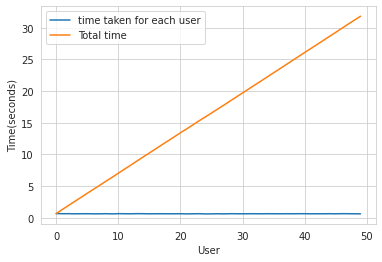

__________________________________________________
time: 0:00:34.348035


In [48]:
#getting memory error
start = datetime.now()
trunc_u_u_sim_matrix, _ = compute_user_similarity(trunc_sparse_matrix, compute_for_few = True, top=50, verbose=True, verb_for_n_rows=10)
print("_"*50)
print("time:",datetime.now()-start)

**Computing Movies-Movies Similarity matrix**





In [49]:
start = datetime.now()
if not os.path.isfile("Movie_Movie_sim_sparse.npz"):
  print("It seems you don't have that file. Computing movie_movie similarity..")
  start = datetime.now()
  m_m_sim_sparse = cosine_similarity(X = train_sparse_matrix.T, dense_output=False)
  print("Done...")
  #store this sparse matrix in disk before using it. For future purposes.
  print("Saving it to disk without the need of re-computing it again...")
  sparse.save_npz("movie_movie_sim_sparse.npz",m_m_sim_sparse)
  print("Done...")
else:
  print("It is there, we will get it.")
  m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
  print("Done...")

print(datetime.now() - start)

It seems you don't have that file. Computing movie_movie similarity..
Done...
Saving it to disk without the need of re-computing it again...
Done...
0:00:35.586426


In [50]:
m_m_sim_sparse.shape

(4500, 4500)

Even though we have similarity measure 
of each movie, with all other movies, we generally don't care much about least similar movies.

Most of the times, only top_xxx similar items matters. It may be 10 or 100.

We take only those top similar movie rating and store them in a saperate dictionary



In [51]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

In [52]:
start = datetime.now()
similar_movies = dict()
for movie in movie_ids:
  #get the top similar movies and store them in the dictionary
  sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
  similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)

#just testing similar movies for movie_15
similar_movies[15]

0:00:02.330339


array([4424, 3755,  590, 3973, 1720, 2818, 4095, 3162, 2280, 2450, 2534,
       1072, 1416, 3338,  376,  598, 2187, 1942, 2716,  565, 1690, 4376,
        847, 1510, 2429, 3706, 1030, 2399, 4486, 2879, 4467, 3502, 2107,
       1391,  882,  509, 3726, 2215, 2637, 4037, 3580, 1493, 3602,  610,
        791, 2764,   31, 3511,  218, 3329, 1696, 2636, 1335,   61, 4326,
       1149, 1184, 4175, 4276, 2859, 2827, 1453, 1177,  280, 1874,  772,
       2219, 3396,  327, 3741, 3016,  914,  714,  679, 2545, 3616, 1647,
       2061, 3294, 1494, 2902, 1930, 4163, 3940, 1575, 4079,  756, 4090,
       1351, 4223, 3941, 3279, 2774, 4006,  917,  277, 2419, 2761, 2624,
       1249])

**Finding most similar movies using similarity matrix**

Does Similarity really work as the way we expected?

Lets pick some random movie and check for its similar movies..

In [53]:
#First lets load the movie details into soe dataframe
#movie details are in 'netflix/movie_titles.csv'

movie_titles = pd.read_csv("/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/movie_titles.csv", sep=',',header=None, names=['movie_id','year_of_release','title'],
                           verbose=True, index_col = 'movie_id', encoding='ISO-8859-1')
movie_titles.head()

Tokenization took: 215.96 ms
Type conversion took: 8.92 ms
Parser memory cleanup took: 0.01 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


**Does similarity really works as the way we expected?**

Let's pick some random movie and check for its similar movies

In [54]:
# First let's load the movie details into soe dataframe..
# movie details are in 'netflix/movie_titles.csv'

movie_titles_df = pd.read_csv("/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/movie_titles.csv", sep = ",",
                           header = None, names = ['MovieID', 'Year_of_Release', 'Movie_Title'], index_col = "MovieID", encoding = "iso8859_2")

In [55]:
movie_titles_df.head()

,Year_of_Release,Movie_Title
MovieID,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [56]:
mv_id = 67

print("\nMovie----------->",movie_titles.loc[mv_id].values[1])
print("\nIt has {} Ratings from users.".format(train_sparse_matrix[:, mv_id].getnnz()))
print("\nWe have {} movies which are similar to this and we will get only top most.".format(m_m_sim_sparse[:,mv_id].getnnz()))
print()


Movie-----------> Vampire Journals

It has 268 Ratings from users.

We have 4369 movies which are similar to this and we will get only top most.



In [57]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()
similar_indices = similarities.argsort()[::-1][1:]
similarities[similar_indices]
similar_indices = similarities.argsort()[::-1][1:] # It will sort and reverse the array and ignore its similarity(i.e., 1)
# and return its indices(movie_ids)

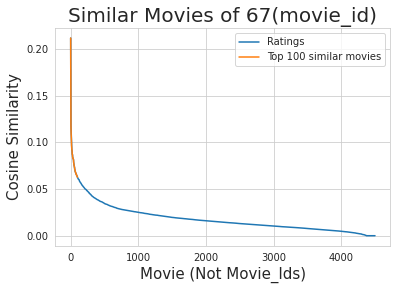

In [58]:
plt.plot(similarities[similar_indices], label = "Ratings")
plt.plot(similarities[similar_indices[:100]], label = "Top 100 similar movies")
plt.title("Similar Movies of {}(movie_id)".format(mv_id), fontsize = 20)
plt.xlabel("Movie (Not Movie_Ids)", fontsize=15)
plt.ylabel("Cosine Similarity", fontsize = 15)
plt.legend()
plt.show()

In [59]:
movie_titles.loc[similar_indices[:10]]

,year_of_release,title
movie_id,,
323,1999.0,Modern Vampires
4044,1998.0,Subspecies 4: Bloodstorm
1688,1993.0,To Sleep With a Vampire
1900,1997.0,Club Vampire
2004,2001.0,She Creature
415,2002.0,Reign in Darkness
3496,1998.0,Vampires
938,2002.0,Scarecrow
2948,1998.0,Razor Blade Smile


Machine Learning Models

In [60]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
  """It will get it from the 'path' if it is present or it will create and store the sampled sparse matrix in the path specified."""
   #get(row, col) and (rating) tuple from sparse matrix.
  row_ind, col_ind, ratings = sparse.find(sparse_matrix)
  users = np.unique(row_ind)
  movies = np.unique(col_ind)

  print("Original Matrix : (users, movies) => ({} {})".format(len(users), len(movies)))
  print("Original Matrix : Ratings -- {}\n".format(len(ratings)))
   # It just to make sure to get same sample everytime we run this program everytime
   # and pick without replacement
  np.random.seed(15)
  sample_users = np.random.choice(users, no_users, replace = False)
  sample_movies = np.random.choice(movies, no_movies, replace=False)

   #get the boolean mask or these sampled items in original row/col_inds
  mask = np.logical_and(np.isin(row_ind, sample_users), np.isin(col_ind, sample_movies))

  sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                            shape=(max(sample_users)+1, max(sample_movies)+1))
   

  if verbose:
    print("Sampled Matrix : (Users, movies) => ({} {})".format(len(sample_users), len(sample_movies)))
    print("Sampled Matrix : Ratings => ".format(ratings[mask].shape[0]))
    print("Saving it into disk for further usages.")
     #save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
      print("Done..\n")
    return sample_sparse_matrix

### **Sampling Data**

Build sample train data from the train data

In [61]:
#train_sparse_matrix = sparse.load_npz("train_sparse_matrix.npz")
#test_sparse_matrix = sparse.load_npz("test_sparse_matrix.npz")
#above are the matrix for all the users and movies
#train_sparse_matrix.shape

In [62]:
# As we know train_sparse_matrix contains matrix for user and movies lets take user and movies from it
start = datetime.now()
path = "/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/sample_train_sparse_matrix.npz"
if os.path.isfile(path):
  print("It is present in your pwd, getting it from disk...")
  # just get it from the disk instead of computing it
  sample_train_sparse_matrix = sparse.load_npz(path)
  print("Done...")
else:
  # get 10k users and 1k movies from available data
  sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=10000, no_movies=1000,path = path)
print(datetime.now() - start)

It is present in your pwd, getting it from disk...
Done...
0:00:00.400373


Build sample test data from the test data

In [63]:
start = datetime.now()

path = "/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/sample_test_sparse_matrix.npz"
if os.path.isfile(path):
  print("It is present in your pwd, getting it from disk...")
  # just get it from the disk instead of computing it
  sample_test_sparse_matrix = sparse.load_npz(path)
  print("Done..")
else:
  #get 5k users and 500 movies from available data
  sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=5000, no_movies=500,path = path)
print(datetime.now() - start)

It is present in your pwd, getting it from disk...
Done..
0:00:00.303951


**Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie(from sampled train)**

In [64]:
sample_train_averages = dict()

Finding Global Averages of all movie ratings

In [65]:
# get the global average of ratings in our train set
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages["global"] = global_average
sample_train_averages

{'global': 3.603744628606507}

**Finding Average rating per User**

In [66]:
sample_train_averages['user'] = get_average_rating(sample_train_sparse_matrix, of_users = True)
print('\nAverage rating of user 195 =',train_averages['user'][195])


Average rating of user 195 = 3.673076923076923


**Finding Average Rating per Movie**

In [67]:
sample_train_averages['movie'] = get_average_rating(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 150 :',sample_train_averages['movie'][150])


 AVerage rating of movie 150 : 2.1666666666666665


**Featurizing data**

In [68]:
print("\nNo of ratings in our Sampled train matrix = {}\n".format(sample_train_sparse_matrix.count_nonzero()))
print("\nNo of ratings in our Sampled test matrix = {}\n".format(sample_test_sparse_matrix.count_nonzero()))


No of ratings in our Sampled train matrix = 127062


No of ratings in our Sampled test matrix = 10988



**Featuring data for regression**

Featurinzing train data

In [69]:
#get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [70]:
sample_train_ratings.shape

(127062,)

In [71]:
start = datetime.now()
if os.path.isfile("/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/reg_train.csv"):
  print("File already exits you don't have to prepare again.")

else:
  print("Preparing {} tuples for the dataset.\n".format(len(sample_train_ratings)))

  with open("/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/reg_train.csv", mode='w') as reg_data_file:
    count = 0
    for (user, movie, rating) in zip(sample_train_users, sample_train_movies, sample_train_ratings):
      st = datetime.now()
      #print(user, movie)
      #Rating of movie by similar user of user
      #compute the similar users of the user

      user_sim = cosine_similarity(sample_test_sparse_matrix[user], sample_test_sparse_matrix).ravel()
      top_sim_users = user_sim.argsort()[::-1][1:]  #we are ignoring the User from its similar user.
      #get the ratings of most similar users for this movie

      top_ratings = sample_test_sparse_matrix[top_sim_users, movie].toarray().ravel()
      #we will make its length '5' by adding movie averages to.

      top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])

      top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5-len(top_sim_users_ratings)))

      #print(top_sim_users_ratings, end = " ")
      #Prepare the row to be stores in a file

      row = list()
      row.append(user)
      row.append(movie)
      # Now add the other features to this data
      row.append(sample_train_averages['global'])  #first feature
      # next five features are similar_users "movie" ratings
      row.extend(top_sim_users_ratings)

      # next 5 features are "user" ratings for similar_movies
      row.extend(top_sim_users_ratings)
      #Avg user rating
      row.append(sample_train_averages['user'][user])
      #Avg movie rating
      row.append(sample_train_averages['movie'][movie])

      #Actual Rating of this user movie pair
      row.append(rating)
      count += 1

      #add rows to the file opened.
      reg_data_file.write(','.join(map(str, row)))
      reg_data_file.write("\n")
      if count%10000 == 0:
        #print(','.join(map(str, row)))
        print("Done for {} row------{}".format(count, datetime.now() - start))

print(datetime.now() - start)

File already exits you don't have to prepare again.
0:00:00.001736


**GAvg :** Average rating of all the ratings

**Similar users rating of this movie:** sur1, sur2, sur3, sur4, sur5(top 5 similar users who rated that movie)

**Similar movies  rated by this user:** smr1, smr2, smr3, smr4, smr5(top 5 similar movies rated by this movie)

**UAvg:** User's Average rating

**MAvg** Average rating of this movie

**Rating** Rating of this movie by this user

In [72]:
reg_train = pd.read_csv("/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/reg_train.csv",
                        names = ['user', 'movie','GAvg','sur1','sur2','sur3','sur4','sur5','smr1',
                                 'smr2','smr3','smr4','smr5','UAvg','MAvg','rating'], header=None)
reg_train.head(10)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,1117050,15,3.603745,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,3.222222,2.250000,2
1,1292631,15,3.603745,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.313131,2.250000,1
2,1550619,15,3.603745,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,4.000000,2.250000,4
3,1719753,15,3.603745,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,3.785714,2.250000,2
4,1830763,15,3.603745,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.978022,2.250000,1
5,1902838,15,3.603745,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.145923,2.250000,1
6,2247936,15,3.603745,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,3.545455,2.250000,4
7,2441503,15,3.603745,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,3.384615,2.250000,3
8,117959,24,3.603745,2.826087,2.826087,2.826087,2.826087,2.826087,2.826087,2.826087,2.826087,2.826087,2.826087,4.725806,2.826087,5
9,133289,24,3.603745,2.826087,2.826087,2.826087,2.826087,2.826087,2.826087,2.826087,2.826087,2.826087,2.826087,4.000000,2.826087,3


**Featurizing test data**

In [73]:
#get users, movies, and rating from the sampled Test
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [74]:
sample_train_averages['global']

3.603744628606507

In [75]:

if os.path.isfile('/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)   

It is already created...


**Reading from the file to make a dataframe**

In [76]:

reg_test_df = pd.read_csv('/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(10)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,760104,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5
1,777147,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5
2,1451564,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5
3,1496376,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,1
4,1748471,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5
5,1934002,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,1
6,1934110,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,1
7,2189335,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,4
8,2411773,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3
9,128259,13,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,4


In [77]:
!pip install surprise

     |████████████████████████████████| 11.8MB 7.0MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617581 sha256=c90c137d56befa8120830b8e0a4ac418e860e192c58eb0bffe226bb211f63a37
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


## **Transforming data for Surprise models**

In [78]:
from surprise import Reader, Dataset

## **Transforming train data**

. We can't give raw data(movie, user, rating) to train the model in Surprise    library.

. They have a seprate format for train and test data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc, in Surprise.

. We can form the trainset from a file, or from a pandas DataFrame.

**Surprise Libraray**
https://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py

In [79]:
# It is to specify how to read the datafram
reader = Reader(rating_scale=(1, 5))

# create the traindata from the dataframe
train_data = Dataset.load_from_df(reg_train[['user', 'user', 'rating']], reader)
#Build the trainset from traindata, it is of dataset format from surprise libraray.
trainset = train_data.build_full_trainset()

### **Transformin test data**

. Testset is just a list of (user, movie, rating) tuples.(Order in the tuple is important

In [80]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(760104, 5, 5), (777147, 5, 5), (1451564, 5, 5)]

## **Machine Learning Models**

. Global dictionary that stores RMSE and MAPE for all the models.

   . It stores the metrics in a dictionary of dictionaries

   **Keys :** model name(string)

   **Value :** dict(key : metric, value: value)

In [81]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

**Utility functions for running regression models**

In [82]:
#To get rmse and mape given actual and predicted ratings.

def get_error_metrics(y_true, y_pred):
  rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
  mape = np.mean(np.abs((y_true - y_pred)/y_true))*100

  return rmse, mape

def run_xgboost(algo, x_train, y_train, x_test, y_test, verbose = True):
    #it will return train and test results

    #dictionaries to store train and test results.

    train_results = dict()
    test_results = dict()

    #fit the model
    print("Training the model...")
    start = datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print("Done. Time taken : {}\n".format(datetime.now() - start))
    print("Done\n")

    #from the trained model, get the predictions..
    print("Evaluating the model with train data...")
    start = datetime.now()
    y_train_pred = algo.predict(x_train)

    #get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)

    #Store the results in train_results dictionary.
    train_results = {'rmse' : rmse_train,
                     "mape" : mape_train,
                     'predictions' : y_train_pred        
    }

    #get the test data predictions and compute rmse and mape
    print("Evaluating test data.")
    y_test_pred = algo.predict(x_test)
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)

    #store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape': mape_test,
                    'predictions': y_test_pred}

    if verbose:
      print("\nTest Data")
      print('-'*50)
      print('RMSE : ', rmse_test)
      print("MAPE : ", mape_test)
    #return these train and test results.
    return train_results, test_results

**Utility functions for surprise modes**

In [83]:
#it is just to make sure taht all of our algorithms should produce same results. Everytime they run

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

#get (actual_list, predicted_list) rating given list of predictions (prediction is a class in surprise)

def get_ratings(predictions):
  actual = np.array([pred.r_ui for pred in predictions])
  pred = np.array([pred.est for pred in predictions])
  return actual, pred


# get 'RMSE' and "MAPE", given list of prediction objects

def get_errors(predictions):
  actual, pred = get_ratings(predictions)
  rmse = np.sqrt(np.mean((pred - actual)**2))
  mape = np.mean(np.abs(pred - actual)/actual)

  return rmse, mape*100

# It will return predicted ratings, rmse and mape of both train and test data

def run_surprise(algo, trainset, testset, verbose=True):
  #return train dict, test_dict. Each of them have 3 key-value pairs, which specify RMSE,
  # MAPE and predicted ratings

  start = datetime.now()
  # dictionaries taht stores metrices for train and test
  train = dict()
  test = dict()

  # train the algorithm with the trainset

  st = datetime.now()
  print("Training the model...")
  algo.fit(trainset)  
  print("Don. time taken : {}\n".format(datetime.now() - st))

  #Evaluating train data
  st = datetime.now()
  print("Evaluating the model with train data...")
  #get the train predictions(list of prediction class inside surprise)

  train_preds = algo.test(trainset.build_testset())
  #get predicted ratings from the train predictions
  train_actual_ratings, train_pred_ratings = get_ratings(train_preds)

  #get RMSE and MAPE from the train predictions
  train_rmse, train_mape = get_errors(train_preds)
  print("time taken : {}".format(datetime.now() - st))
  
  if verbose:
    print('-'*20)
    print('Train Data')
    print('-'*20)
    print('RMSE : {}\n\nMAPE : {}\n'.format(train_rmse, train_mape))

    #store them in the train dictionary
  if verbose:
    print('Adding train results in the dictionary.')
  train['rmse'] = train_rmse
  train['mape'] = train_mape
  train['predictions'] = train_pred_ratings

  #Evaluating test data
  st = datetime.now()
  print('\nEvaluating for test data.')
  #get the predictions(list of prediction classes) of test data
  test_preds = algo.test(testset)
  #get the predicted ratings from the list of predictions

  test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
  # get error metrics from the predicted and actual ratings

  test_rmse, test_mape = get_errors(test_preds)
  print('Time taken : {}'.format(datetime.now() - st))

  if verbose:
    print('-'*20)
    print('Test Data')
    print('-'*20)
    print('RMSE : {}\n\nMAPE : {}\n'.format(test_rmse, test_mape))

  #store them in test dictionary
  if verbose:
    print('Storing the test results in test dictionary.')
  test['rmse'] = test_rmse
  test['mape'] = test_mape
  test['predictions'] = test_pred_ratings
  print('\n'+"-"*50)
  print('Toatl time taken to run this algorithm : ', datetime.now() - start)
  return train, test

### **XGBoost with initial 13 features**

In [84]:
import xgboost as xgb
from scipy.stats import randint as sp_randint
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

TUning parameter: 

Time taken to tune : 0:02:28.370774

Training the model...
Done. Time taken : 0:00:20.588637

Done

Evaluating the model with train data...
Evaluating test data.

Test Data
--------------------------------------------------
RMSE :  1.0510168639694484
MAPE :  31.78603542243779


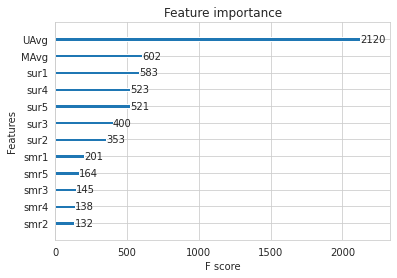

In [85]:
#prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

#prepare test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

#Hyperparameter tuning

param = {'learning_rate' : stats.uniform(0.01, 0.2),
         'n_estimators' : sp_randint(100, 1000),
         'max_depth' : sp_randint(1, 10),
         'min_child_weight' : sp_randint(1,8),
         'gamma': stats.uniform(0, 0.02),
         'subsample':stats.uniform(0.6, 0.4),
         'reg_alpha' :sp_randint(0, 200),
         'reg_lambda':stats.uniform(0, 200),
         'colsample_bytree' : stats.uniform(0.6, 0.3)
         }

#initialize our first xgboost model
xgbreg = xgb.XGBRegressor(silent=True, n_jobs=-1, random_state=15)
start = datetime.now()
print("TUning parameter: \n")
xgb_best = RandomizedSearchCV(xgbreg, param_distributions=param,refit=False, scoring='neg_mean_squared_error',
                              cv = 3, n_jobs = -1)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_
first_xgb = xgbreg.set_params(**best_para)

print("Time taken to tune : {}\n".format(datetime.now() - start))

train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

#store the results in models evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

### **Surprise Baseline Model**

In [86]:
from surprise import BaselineOnly

### **Predicting_rating : (baseline prediction)**

 http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly 

 image.png

 mu - Average of all rating in training data

 
 bu - User bias


 bi - item bias(movie biases)

### **Optimization function(Least Square Problem)**

http://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baselines-estimates-configuration 


image.png

In [87]:
#options are to specify., how to compute those user and item biases

bsl_options = {'method' : 'sgd',
               'learninig_rate' : .001
    
}

bsl_algo = BaselineOnly(bsl_options = bsl_options)
#it will return train and test results

bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)

#just stores these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Don. time taken : 0:00:00.413414

Evaluating the model with train data...
time taken : 0:00:00.436469
--------------------
Train Data
--------------------
RMSE : 0.9306463853672049

MAPE : 28.627714951730436

Adding train results in the dictionary.

Evaluating for test data.
Time taken : 0:00:00.105458
--------------------
Test Data
--------------------
RMSE : 1.0538747947660807

MAPE : 32.253564484203665

Storing the test results in test dictionary.

--------------------------------------------------
Toatl time taken to run this algorithm :  0:00:00.958378


## **XGBoost with initial 13 features and Surprise Baseline Predictor**

**Updating Train Data**

In [88]:
#add our baseline_predicted value as our feature
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,1117050,15,3.603745,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,3.222222,2.25,2,3.421890
1,1292631,15,3.603745,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.313131,2.25,1,3.421890
2,1550619,15,3.603745,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,4.000000,2.25,4,3.421890
3,1719753,15,3.603745,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,3.785714,2.25,2,3.421890
4,1830763,15,3.603745,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.978022,2.25,1,2.336162


**Updating Test Data**

In [89]:
# add that baseline predicted ratings with surprise to the test data as well
reg_test_df['bslpr'] = models_evaluation_test['bsl_algo']['predictions']

reg_test_df.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,760104,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5,3.624708
1,777147,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5,3.624708
2,1451564,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5,3.624708
3,1496376,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,1,3.624708
4,1748471,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5,3.624708


Tuning parameters.

Time taken to tune : 0:04:49.315362

Training the model...
Done. Time taken : 0:00:08.214572

Done

Evaluating the model with train data...
Evaluating test data.

Test Data
--------------------------------------------------
RMSE :  1.0456337282621742
MAPE :  31.904694166754567


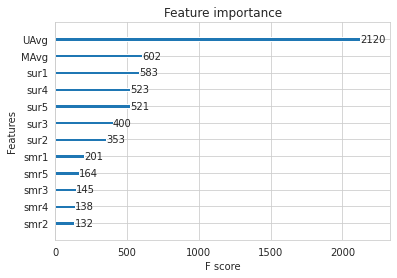

In [90]:
#prepare train data

x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

#preparing test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']


params = {'learning_rate' : stats.uniform(0.01, 0.2),
          'n_estimators':sp_randint(100,1000),
          'max_depth': sp_randint(1, 10),
          'min_child_weight':sp_randint(1, 8),
          'gamma' : stats.uniform(0, 0.02),
          'subsample': stats.uniform(0.6,0.4),
          'reg_alpha' : sp_randint(0, 200),
          'reg_lambda': stats.uniform(0, 200),
          'colsample_bytree' : stats.uniform(0.6, 0.3)
}

#initialize xgboost model.
xgbreg = xgb.XGBRegressor(silent=True, n_jobs=-1, random_stats=15)
start = datetime.now()
print('Tuning parameters.\n')
xgb_best = RandomizedSearchCV(xgbreg, param_distributions=params, refit=False, scoring = 'neg_mean_squared_error',
                              n_jobs = -1, cv = 3)

xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_

xgb_bsl = xgbreg.set_params(**best_para)
print('Time taken to tune : {}\n'.format(datetime.now()-start))

train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

#stores the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

## **Suprise KNNBaseline Predictor**

**KNN BASELINE**


http://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline


**Pearson baseline similarity**

http://surprise.readthedocs.io/en/stable/similarities.html#surprise.similarities.pearson_baseline



**shrinkage**

neighborhood models in

http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf

In [91]:
from surprise import KNNBaseline

#we specify, how to compute similarities and what to consider with sim_options to our algorithm

sim_options = {'user_based': True,
               'name': 'pearson_baseline',
               'shrinkage':100,
               'min_support':2    
}

#we keep other parameters like regularization parameter and learning rate as default values.
bsl_options = {'method':'sgd'}
knn_bsl_u = KNNBaseline(k=40, sim_options= sim_options, bsl_options = bsl_options)

knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

#just store these error metrics in our models_evaluation datastructure

models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Don. time taken : 0:00:03.187497

Evaluating the model with train data...
time taken : 0:00:02.065501
--------------------
Train Data
--------------------
RMSE : 0.8955304404631884

MAPE : 26.4188618421069

Adding train results in the dictionary.

Evaluating for test data.
Time taken : 0:00:00.213156
--------------------
Test Data
--------------------
RMSE : 1.0538747947660807

MAPE : 32.253564484203665

Storing the test results in test dictionary.

--------------------------------------------------
Toatl time taken to run this algorithm :  0:00:05.467842


**Surprise KNNBaseline with movie movie similarities**

In [92]:
#we specify, how to compute similarities and what to consider with sim_options to our algorithm

#'user_based' : False => this consider the similarities of movies instead of users

sim_options = {'user_based' : False,
               'name':'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
               }

#we keep other parameter like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}

knn_bsl_m = KNNBaseline(k=40, sim_options=sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

#just store these error metrics in our models_evaluation datastructure

models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Don. time taken : 0:00:02.645887

Evaluating the model with train data...
time taken : 0:00:02.086238
--------------------
Train Data
--------------------
RMSE : 0.8955304404631884

MAPE : 26.4188618421069

Adding train results in the dictionary.

Evaluating for test data.
Time taken : 0:00:00.114189
--------------------
Test Data
--------------------
RMSE : 1.0538747947660807

MAPE : 32.253564484203665

Storing the test results in test dictionary.

--------------------------------------------------
Toatl time taken to run this algorithm :  0:00:04.847423


### **XGBoost with initial 13 features, Surprise Baseline Predictor And KNNBaseline Predictor**



*  First we will run XGBoost with predictions from both KNN's(User_User and Item_Item similarities along with previous features).
*   Then we will run XGBoost with just predictions from both knn models and predictions from our baseline model.



**Preparing Train Data**

In [93]:
#add the predicted values from both knn to this dataframe

reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,1117050,15,3.603745,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,3.222222,2.25,2,3.421890,3.25,3.25
1,1292631,15,3.603745,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.313131,2.25,1,3.421890,3.25,3.25
2,1550619,15,3.603745,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,4.000000,2.25,4,3.421890,3.25,3.25
3,1719753,15,3.603745,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,3.785714,2.25,2,3.421890,3.25,3.25
4,1830763,15,3.603745,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.978022,2.25,1,2.336162,2.30,2.30


**Preparing Test Data**

In [94]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,760104,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5,3.624708,3.624708,3.624708
1,777147,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5,3.624708,3.624708,3.624708
2,1451564,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5,3.624708,3.624708,3.624708
3,1496376,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,1,3.624708,3.624708,3.624708
4,1748471,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5,3.624708,3.624708,3.624708


Tuning parameter

Time taken to tune : 0:04:23.193545

Training the model...
Done. Time taken : 0:00:07.812186

Done

Evaluating the model with train data...
Evaluating test data.

Test Data
--------------------------------------------------
RMSE :  1.0470337645723384
MAPE :  31.818135256089423


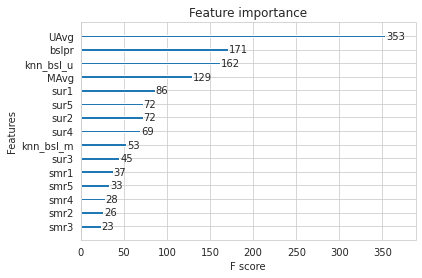

In [95]:
#prepare the train data

x_train = reg_train.drop(['user','movie', 'rating'], axis = 1)
y_train = reg_train['rating']


#prepare the train data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']

params = {'learning_rate' : stats.uniform(0.01, 0.2),
          'n_estimators':sp_randint(100, 1000),
          'max_depth' : sp_randint(1, 10),
          'min_child_weight': sp_randint(1,8),
          'gamma': stats.uniform(0, 0.02),
          'subsample' : stats.uniform(0.6, 0.4),
          'reg_alpha' : sp_randint(0, 200),
          'reg_lambda': stats.uniform(0, 200),
          'colsample_bytree':stats.uniform(0.6, 0.3)
    
}

#Declare xgboost model

xgbreg = xgb.XGBRegressor(silent=True, n_jobs=-1, random_state=15)
start = datetime.now()
print("Tuning parameter\n")
xgb_best = RandomizedSearchCV(xgbreg, param_distributions=params, refit=False, scoring='neg_mean_squared_error',
                              n_jobs=-1, cv=3)

xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_

xgb_knn_bsl = xgbreg.set_params(**best_para)
print('Time taken to tune : {}\n'.format(datetime.now() - start))

train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

#store the results in model_evaluations dictionaries

models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results

xgb.plot_importance(xgb_knn_bsl)
plt.show()

## **Matrix Factorization Techniques**

**SVD Matrix Factorization user movie intractions**

In [96]:
from surprise import SVD

### **Predicting Rating:**

### **Optimazation problem with user item interactios and regularization(to avoid overfitting)**

In [97]:
#initialize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

#just store these error metrics in our models_evaluation datastructure

models_evaluation_train['svd'] = svd_train_results
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Don. time taken : 0:00:02.944834

Evaluating the model with train data...
time taken : 0:00:00.619209
--------------------
Train Data
--------------------
RMSE : 0.9130338335710877

MAPE : 27.840056724141387

Adding train results in the dictionary.

Evaluating for test data.
Time taken : 0:00:00.105820
--------------------
Test Data
--------------------
RMSE : 1.053972338086155

MAPE : 32.25979142901061

Storing the test results in test dictionary.

--------------------------------------------------
Toatl time taken to run this algorithm :  0:00:03.670865


In [100]:
#initialize the model
from surprise import SVDpp
svdpp = SVDpp(n_factors=50, random_state = 15, verbose=True)
svdpp_train_results, svdapp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

#just store these error metrics in our model_evaluation datastructure

models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results



Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Don. time taken : 0:00:22.073929

Evaluating the model with train data...
time taken : 0:00:01.762818
--------------------
Train Data
--------------------
RMSE : 0.9071335746302033

MAPE : 27.512404658542128

Adding train results in the dictionary.

Evaluating for test data.
Time taken : 0:00:00.108199
--------------------
Test Data
--------------------
RMSE : 1.0541369616181917

MAPE : 32.266986975290266

Storing the test results in test dictionary.

--------------------------------------------------
Toatl time taken to run this algorithm :  0:00:23.945852


### **SVD Matrix Factorization with implicit feedback from user (user rated movie)**

# **Predictd Rating**

### **Optimization problem  with user item interactions and regularization(to avoid overfitting)**

In [101]:
#initialize the model
svdpp = SVDpp(n_factors = 50, random_state = 15, verbose = True)
svdpp_train_results, svd_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

#

Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Don. time taken : 0:00:22.030622

Evaluating the model with train data...
time taken : 0:00:01.566768
--------------------
Train Data
--------------------
RMSE : 0.9071335746302033

MAPE : 27.512404658542128

Adding train results in the dictionary.

Evaluating for test data.
Time taken : 0:00:00.103764
--------------------
Test Data
--------------------
RMSE : 1.0541369616181917

MAPE : 32.266986975290266

Storing the test results in test dictionary.

--------------------------------------------------
Toatl time taken to run this algorithm :  0:00:23.703575


**SVD Matrix factorization with implicit feedback from user(user rated movies)**

### **Predicted Rating:**

### **Optimiazation problem with user item interactions and regularization(to avoid overfitting)**

In [104]:
#initialize  the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdapp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

#just store these error metrics in our model evaluation datastructure

models_evaluation_train['svdpp'] = svdpp_train_results
models_evaluation_test['svdpp'] = svdapp_test_results

Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Don. time taken : 0:00:22.256272

Evaluating the model with train data...
time taken : 0:00:01.646581
--------------------
Train Data
--------------------
RMSE : 0.9071335746302033

MAPE : 27.512404658542128

Adding train results in the dictionary.

Evaluating for test data.
Time taken : 0:00:00.107972
--------------------
Test Data
--------------------
RMSE : 1.0541369616181917

MAPE : 32.266986975290266

Storing the test results in test dictionary.

--------------------------------------------------
Toatl time taken to run this algorithm :  0:00:24.013667


## **XgBoost with 13 features and Surprise Baseline, Surprise KNNBaseline and MF techniques**

**Preparing Train data**

In [105]:
#add the predicted values from both knn to this dataframe

reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,1117050,15,3.603745,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,3.222222,2.25,2,3.421890,3.25,3.25,3.344186,3.288634
1,1292631,15,3.603745,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.313131,2.25,1,3.421890,3.25,3.25,3.344186,3.288634
2,1550619,15,3.603745,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,4.000000,2.25,4,3.421890,3.25,3.25,3.344186,3.288634
3,1719753,15,3.603745,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,3.785714,2.25,2,3.421890,3.25,3.25,3.344186,3.288634
4,1830763,15,3.603745,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.25,2.978022,2.25,1,2.336162,2.30,2.30,2.335511,2.481326


**Preparing test data**

In [106]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,760104,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5,3.624708,3.624708,3.624708,3.624708,3.624708
1,777147,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5,3.624708,3.624708,3.624708,3.624708,3.624708
2,1451564,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5,3.624708,3.624708,3.624708,3.624708,3.624708
3,1496376,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,1,3.624708,3.624708,3.624708,3.624708,3.624708
4,1748471,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5,3.624708,3.624708,3.624708,3.624708,3.624708


Tuning parameter : 

Time taken to tune:0:02:42.914803

Training the model...
Done. Time taken : 0:00:10.842778

Done

Evaluating the model with train data...
Evaluating test data.

Test Data
--------------------------------------------------
RMSE :  1.0470320063662757
MAPE :  31.801968359452488


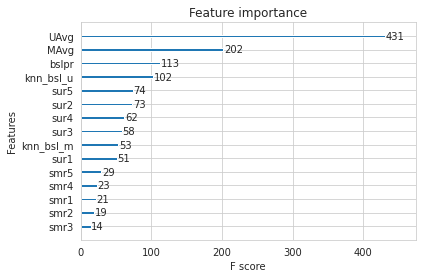

In [103]:
#preparing x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

#prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis = 1)
y_test = reg_test_df['rating']


params = {'learning_rate':stats.uniform(0.01, 0.2),
          'n_estimators':sp_randint(100, 1000),
          'max_depth':sp_randint(1,10),
          'min_child_weight':sp_randint(1, 8),
          'gamma':stats.uniform(0, 0.02),
          'subsample':stats.uniform(0.6, 0.4),
          'reg_alpha':sp_randint(0, 200),
          'reg_lambda':stats.uniform(0, 200),
          'colsample_bytree':stats.uniform(0.6, 0.3)  
}

#Declare XGBoost model..
xgbreg = xgb.XGBRegressor(silent=True, n_jobs=-1, random_state=15)
start = datetime.now()
print("Tuning parameter : \n")

xgb_best = RandomizedSearchCV(xgbreg, param_distributions=params, refit=False, scoring="neg_mean_squared_error",
                              n_jobs = -1, cv = 3)

xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_

xgb_final = xgbreg.set_params(**best_para)
print("Time taken to tune:{}\n".format(datetime.now()-start))

train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

#store the results in the models_evaluation dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results

xgb.plot_importance(xgb_final)
plt.show()

### **XgBoost with Surprise Baseline, Surprise KNNbaseline and MF techniques**

Tuning parameter:

Training the model...
Done. Time taken : 0:00:02.171799

Done

Evaluating the model with train data...
Evaluating test data.

Test Data
--------------------------------------------------
RMSE :  1.055226327436739
MAPE :  32.23471171361066


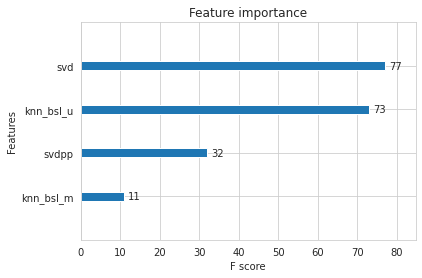

In [109]:
#prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m','svd', 'svdpp']]
y_train = reg_train['rating']

#test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']

params = {'learning_rate':stats.uniform(0.01, 0.2),
          'n_estimators': sp_randint(100, 1000),
          'max_depth':sp_randint(1, 10),
          'min_child_weight':sp_randint(1, 8),
          'gamma':stats.uniform(0, 0.02),
          'subsample':stats.uniform(0.6, 0.4),
          'reg_alpha':sp_randint(0, 200),
          'reg_lambda':stats.uniform(0, 200),
          'colsample_bytree':stats.uniform(0.6, 0.3)
}

#Declare XGBoost model

xgbreg = xgb.XGBRegressor(silent=True, n_jobs=-1, random_state=15)
start = datetime.now()

print("Tuning parameter:\n")
xgb_best = RandomizedSearchCV(xgbreg, param_distributions=params, refit=False, scoring="neg_mean_squared_error", n_jobs=-1, cv = 3)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_

xgb_all_models = xgbreg.set_params(**best_para)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

# **Comparision Between all Models**


### **With tuned Hyperparameter model Performance**

In [111]:
pd.DataFrame(models_evaluation_test).to_csv('/content/drive/MyDrive/ML_Projects/Facebook_Recommandation/tuned_small_sample_results.csv')
models = pd.read_csv('/content/drive/MyDrive/ML_Projects/Facebook_Recommandation/tuned_small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()



xgb_final         1.0470320063662757
xgb_knn_bsl       1.0470337645723384
first_algo        1.0510168639694484
bsl_algo          1.0538747947660807
knn_bsl_u         1.0538747947660807
knn_bsl_m         1.0538747947660807
svd                1.053972338086155
svdpp             1.0541369616181917
xgb_all_models     1.055226327436739
Name: rmse, dtype: object

### **Plot of Train and Test RMSE of tuned Hyperparameter model performance**

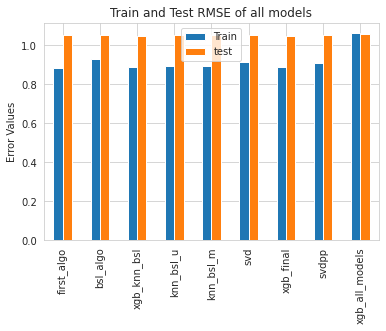

In [113]:
train_performance = pd.DataFrame(models_evaluation_train)
test_performance = pd.DataFrame(models_evaluation_test)

performance_dataframe = pd.DataFrame({'Train': train_performance.loc['rmse'], 'test':test_performance.loc['rmse']})

performance_dataframe.plot(kind='bar', grid=True)
plt.title("Train and Test RMSE of all models")
plt.ylabel("Error Values")
plt.show()

## **Conclusion**